In [37]:
import pandas as pd
import pathlib
import sys
from functools import partial
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import numpy as np
import warnings

path = str(pathlib.Path().resolve().parent)
sys.path.append(path)
sys.path.append(path+'/src/')
warnings.simplefilter("ignore")

from src.preprocessing import *

In [2]:
%load_ext autoreload
%autoreload 2

In [52]:
data = pd.read_csv(path + '/data/final_merged_dataset.csv',index_col = 0)

#Feature nb of retweets :

data['nb_retweets'] = data['tweet'].apply(count_retweets)

#Feature nb of mentions :

data['nb_mentions'] = data['tweet'].apply(count_mentions)

#Feature nb of urls:

data['nb_urls'] = data['tweet'].apply(count_urls)

#Feature nb of hashtags :

data['nb_hashtags'] = data['tweet'].apply(count_hashtags)

# Remove emojis :

data['tweet'] = data['tweet'].apply(remove_emojis)

# Remove retweets :

data['tweet'] = data['tweet'].apply(remove_retweets)

# Remove mentions :

data['tweet'] = data['tweet'].apply(remove_mentions)

# Remove urls :

#data['tweet'] = data['tweet'].apply(remove_urls)

# Remove hashtags :

data['tweet'] = data['tweet'].apply(remove_hashtags)

# Replace slash chars (\n, \t, \r) by space :

data['tweet'] = data['tweet'].apply(replace_slash_chars_by_space)

# Remove underscore :

data['tweet'] = data['tweet'].apply(remove_underscore)

# Remove html stuff (like &lt;) :

data['tweet'] = data['tweet'].apply(remove_html_stuff)

# To lowercase :

data['tweet'] = data['tweet'].apply(to_lowercase)

# Remove stopwords :

with open(path + "/data/english_stopwords.txt",mode="r") as f:
    stopwords = f.read().split('\n')

additional_stopwords = [] # to change
to_remove_stopwords = [] # to change

final_stopwords = [s for s in stopwords if s not in to_remove_stopwords]
final_stopwords += additional_stopwords

remove_stp_words = partial(remove_stopwords,list_stopwords=final_stopwords)

data['tweet'] = data['tweet'].apply(remove_stp_words)

# Remove additional white space :

data['tweet'] = data['tweet'].apply(remove_additional_space)

data.head()

,tweet,label,nb_retweets,nb_mentions,nb_urls,nb_hashtags
0,two weeks coronavirus media coverage and: new ...,0,1,1,0,0
1,"ever here, congratulations, immune coronavirus...",0,1,1,1,0
2,you’ve ever used frat house bathroom you’re im...,0,1,1,0,0
3,cocaine cures corona virus!! . got interesting...,0,1,1,0,0
4,it’s almost whole lot americans covid immune s...,0,1,1,0,0


Distribution du nombre de mots entre Fake news et Real news :

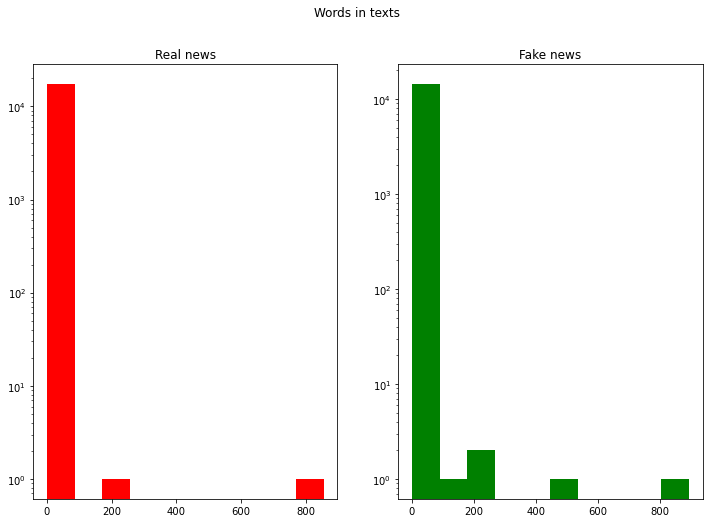

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=data[data['label']==1]['tweet'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red',log=True)
ax1.set_title('Real news')
text_len=data[data['label']==0]['tweet'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green',log=True)
ax2.set_title('Fake news')
fig.suptitle('Words in texts')
plt.show()

Word cloud des vrai news :

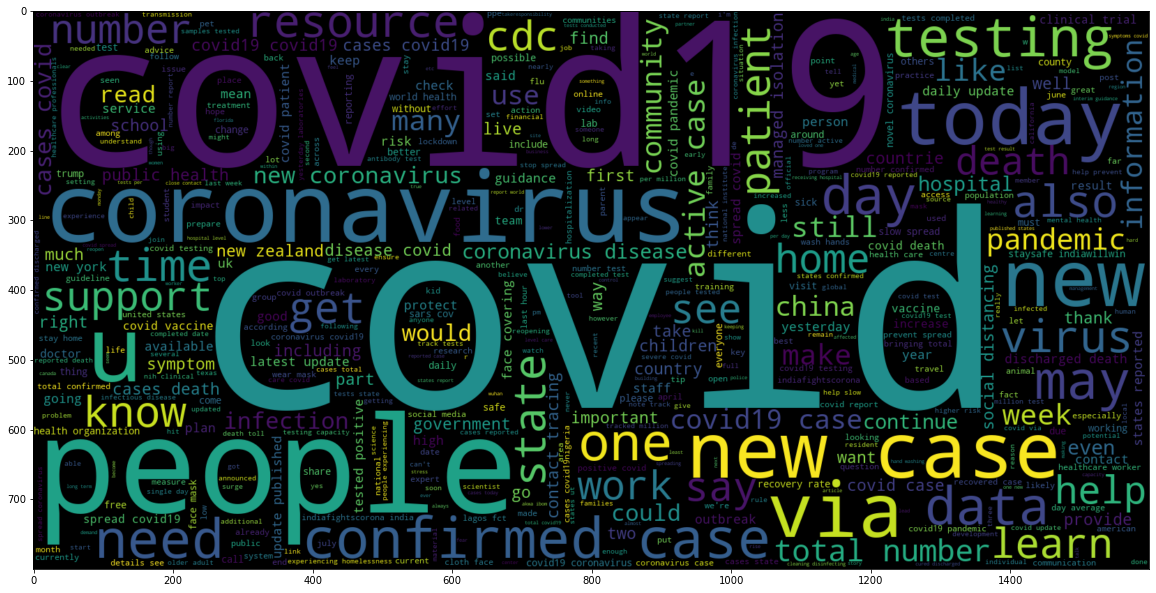

In [14]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = stopwords).generate(" ".join(data[data.label == 1].tweet))
plt.imshow(wc , interpolation = 'bilinear');

Wordcloud des fake news :

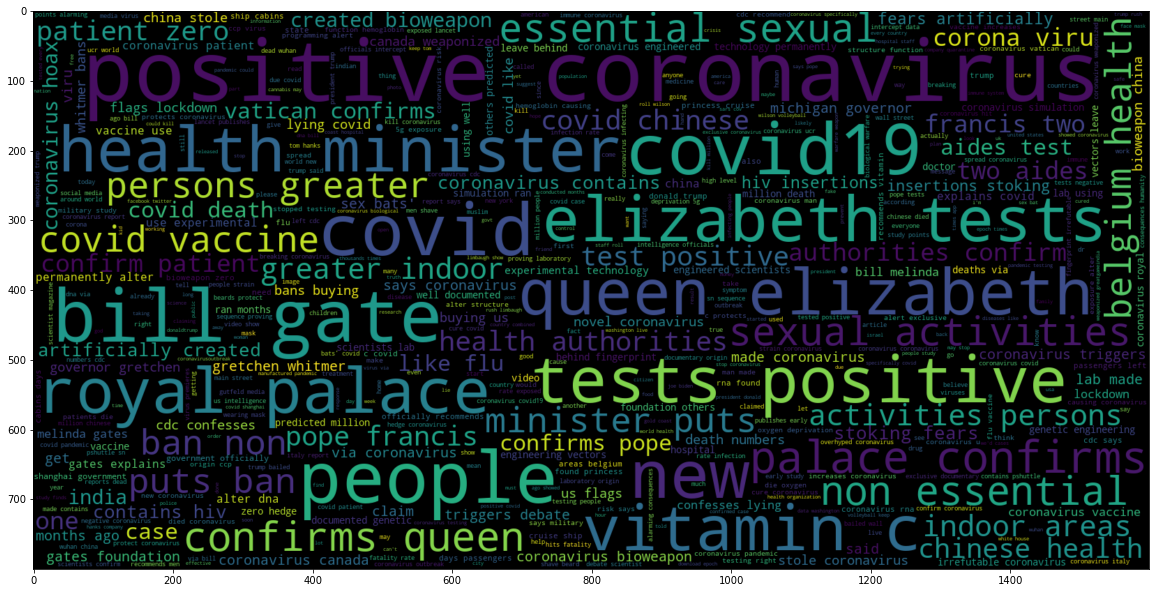

In [13]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = stopwords).generate(" ".join(data[data.label == 0].tweet))
plt.imshow(wc , interpolation = 'bilinear');

Comparaison de la longueur des mots entre fake et real news :

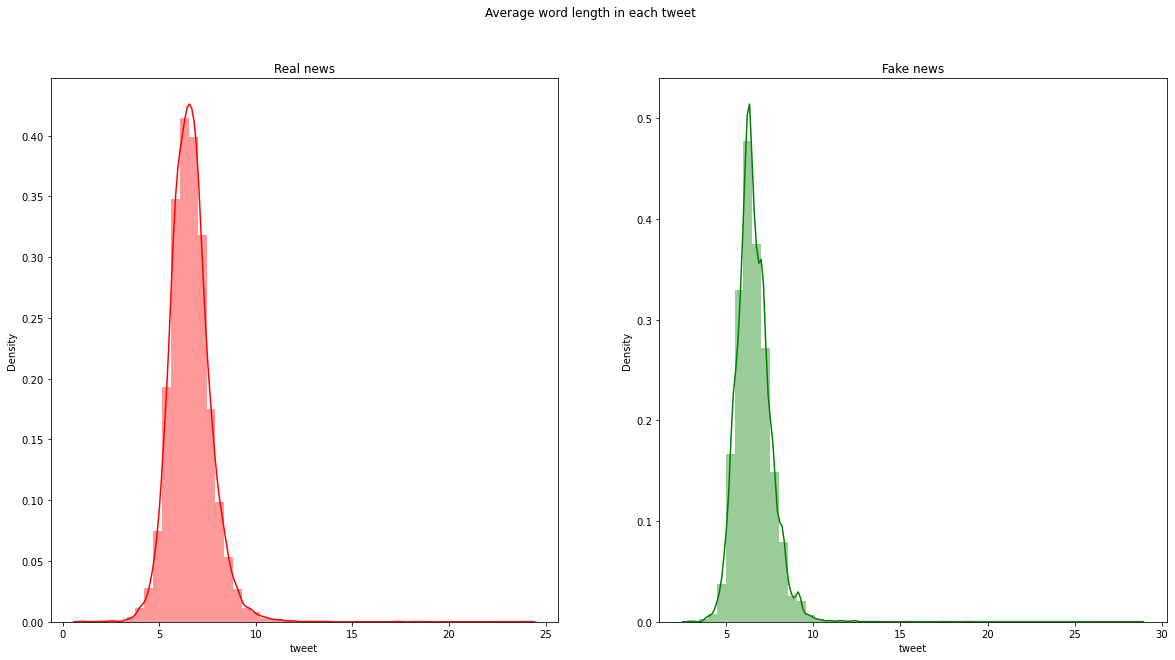

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=data[data['label']==1]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Real news')
word=data[data['label']==0]['tweet'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Fake news')
fig.suptitle('Average word length in each tweet');

In [53]:
train_df, val_df = train_val_split(data)
X_train = train_df['tweet'].values
y_train = train_df['label'].values
X_val = val_df['tweet'].values
y_val = val_df['label'].values

In [54]:
max_words = 1000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
train_sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = sequence.pad_sequences(train_sequences,maxlen=max_len)
val_sequences = tok.texts_to_sequences(X_val)
val_sequences_matrix = sequence.pad_sequences(val_sequences,maxlen=max_len)

In [55]:
def RNN():
    inputs = keras.Input(name='inputs',shape=[max_len])
    layer = keras.layers.Embedding(max_words,50,input_length=max_len)(inputs)
    layer = keras.layers.LSTM(64)(layer)
    layer = keras.layers.Dense(256,name='FC1')(layer)
    layer = keras.layers.Activation('relu')(layer)
    layer = keras.layers.Dropout(0.5)(layer)
    layer = keras.layers.Dense(1,name='out_layer')(layer)
    layer = keras.layers.Activation('sigmoid')(layer)
    model = keras.Model(inputs=inputs,outputs=layer)
    return model

In [56]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer="adam",metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 200)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 200, 50)           50000     
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_12 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [57]:
model.fit(train_sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.1,callbacks=[
              keras.callbacks.EarlyStopping(
                  monitor='val_loss'
                  )
              ]
              )

Epoch 1/10
203/203 [==============================] - 71s 334ms/step - loss: 0.3573 - accuracy: 0.8385 - val_loss: 0.2693 - val_accuracy: 0.8958


In [58]:
y_pred = model.predict(val_sequences_matrix)
y_pred = (y_pred > 0.5).astype('int').ravel()
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1463
           1       0.92      0.87      0.89      1738

    accuracy                           0.89      3201
   macro avg       0.88      0.89      0.88      3201
weighted avg       0.89      0.89      0.89      3201

